In [33]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import os,sys
opj = os.path.join
from copy import deepcopy
import pickle as pkl
from tqdm import tqdm

from sim_biology import p, load_dataloader_and_pretrained_model
# adaptive-wavelets modules
sys.path.append('../../src')
sys.path.append('../../src/adaptive_wavelets')
from losses import get_loss_f
from train import Trainer
from evaluate import Validator
from transform1d import DWT1d
from utils import get_1dfilts
from wave_attributions import Attributer
from visualize import cshow, plot_1dreconstruct, plot_1dfilts

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## load data and model

In [34]:
# get dataloader and model
(train_loader, test_loader), model = load_dataloader_and_pretrained_model(p)

In [35]:
# get image
data = iter(test_loader).next()[0].to(device)

# wavelet transform 
wt = DWT1d(wave='db10', mode='zero', J=4, init_factor=1, noise_factor=0.1).to(device)

data_t = wt(data)
recon = wt.inverse(data_t)

print("Reconstruction error={:.5f}".format(torch.norm(recon - data)**2/data.size(0)))

# get 1d wavelet filters
filt = get_1dfilts(wt)

Reconstruction error=5.06133


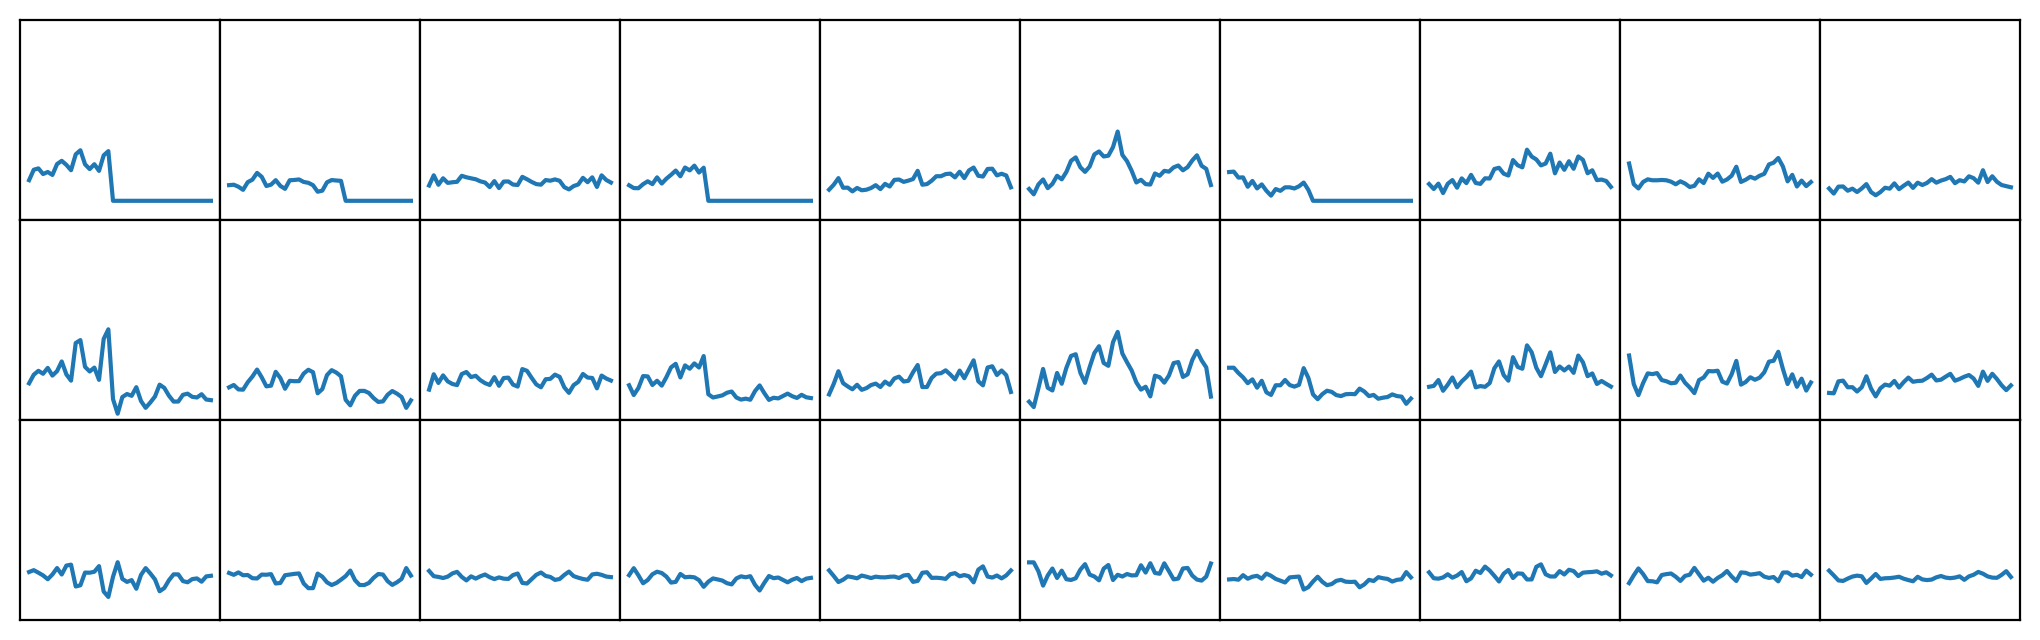

In [36]:
# plot original and reconstruction images
plot_1dreconstruct(data, recon)

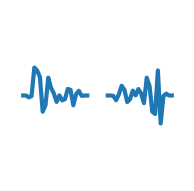

In [37]:
# plot wavelet filters
plot_1dfilts(filt, figsize=(1,1))

## optimize filter

In [38]:
# train
params = list(wt.parameters())
optimizer = torch.optim.Adam(params, lr=0.001)
loss_f = get_loss_f(lamSum=1, lamL2norm=1, lamCMF=1, lamL1wave=0.0, lamL1attr=100.0)
trainer = Trainer(model, wt, optimizer, loss_f, target=0, 
                  use_residuals=True, attr_methods='Saliency', device=device, n_print=50)

In [39]:
trainer(train_loader, epochs=500)

Starting Training Loop...
Train Epoch: 0 [1044/2936 (97%)]	Loss: 80.477493
====> Epoch: 0 Average train loss: 76.2578
Train Epoch: 50 [1044/2936 (97%)]	Loss: 34.041794
====> Epoch: 50 Average train loss: 33.8098
Train Epoch: 100 [1044/2936 (97%)]	Loss: 34.145325
====> Epoch: 100 Average train loss: 33.2696
Train Epoch: 150 [1044/2936 (97%)]	Loss: 36.514626
====> Epoch: 150 Average train loss: 33.2569
Train Epoch: 200 [1044/2936 (97%)]	Loss: 35.132870
====> Epoch: 200 Average train loss: 33.2501
Train Epoch: 250 [1044/2936 (97%)]	Loss: 33.126850
====> Epoch: 250 Average train loss: 33.0927
Train Epoch: 300 [1044/2936 (97%)]	Loss: 34.060284
====> Epoch: 300 Average train loss: 33.2692
Train Epoch: 350 [1044/2936 (97%)]	Loss: 37.672356
====> Epoch: 350 Average train loss: 33.2929
Train Epoch: 400 [1044/2936 (97%)]	Loss: 30.594711
====> Epoch: 400 Average train loss: 33.1231
Train Epoch: 450 [1044/2936 (97%)]	Loss: 30.883884
====> Epoch: 450 Average train loss: 32.9315


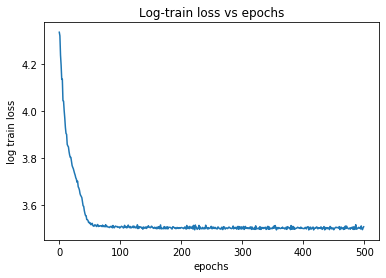

In [40]:
plt.plot(np.log(trainer.train_losses))
plt.xlabel("epochs")
plt.ylabel("log train loss")
plt.title('Log-train loss vs epochs')
plt.show()

In [41]:
data_t = wt(data)
recon = wt.inverse(data_t)

print("Reconstruction error={:.5f}".format(torch.norm(recon - data)**2/data.size(0)))

# get 2d wavelet filters
filt = get_1dfilts(wt)

Reconstruction error=5.05046


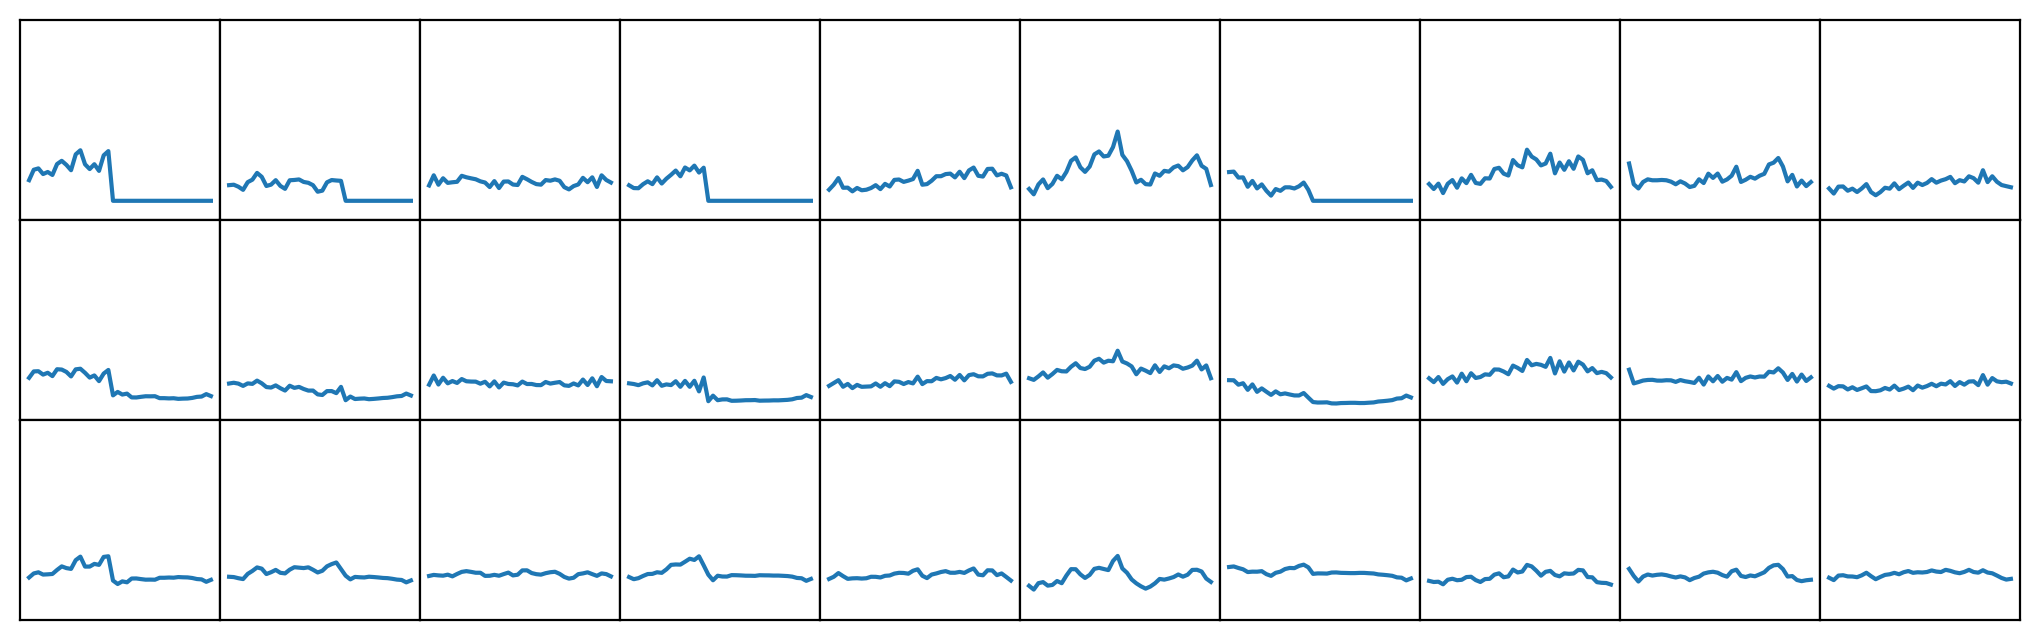

In [42]:
# plot original and reconstruction images
plot_1dreconstruct(data, recon)

## test error

In [43]:
# validator 
validator = Validator(model, test_loader)
rec_loss, sum_loss, L2norm_loss, CMF_loss, L1wave_loss, L1saliency_loss, L1inputxgrad_loss = validator(wt, target=0)

# original wavelet transform
wt_o = DWT1d(wave='db5', mode='zero', J=4, init_factor=1, noise_factor=0).to(device)
rec_loss_o, sum_loss_o, L2norm_loss_o, CMF_loss_o, L1wave_loss_o, L1saliency_loss_o, L1inputxgrad_loss_o = validator(wt_o, target=0)

print("\n\n \t Original filter:Reconstruction Error={:.5f} sum loss={:.5f} L2norm loss={:.5f} CMF loss={:.5f} L1wave loss={:.5f} L1saliency loss={:.5f} L1inputxgrad loss={:.5f} \n \
        Adaptive filter:Reconstruction Error={:.5f} sum loss={:.5f} L2norm loss={:.5f} CMF loss={:.5f} L1wave loss={:.5f} L1saliency loss={:.5f} L1inputxgrad loss={:.5f}"\
          .format(rec_loss_o, sum_loss_o, L2norm_loss_o, CMF_loss_o, L1wave_loss_o, L1saliency_loss_o, L1inputxgrad_loss_o, 
                  rec_loss, sum_loss, L2norm_loss, CMF_loss, L1wave_loss, L1saliency_loss, L1inputxgrad_loss))



 	 Original filter:Reconstruction Error=0.00000 sum loss=0.00000 L2norm loss=0.00000 CMF loss=0.00000 L1wave loss=4.32779 L1saliency loss=0.42663 L1inputxgrad loss=0.27994 
         Adaptive filter:Reconstruction Error=5.01368 sum loss=0.00154 L2norm loss=0.03200 CMF loss=0.24365 L1wave loss=3.29296 L1saliency loss=0.26433 L1inputxgrad loss=0.19072


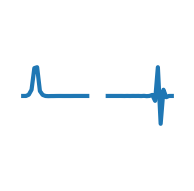

In [44]:
# plot wavelet filters
filt = get_1dfilts(wt)
plot_1dfilts(filt, figsize=(1,1))

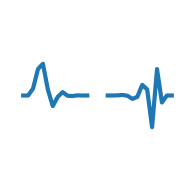

In [45]:
# plot original wavelet filters
filt_o = get_1dfilts(wt_o)
plot_1dfilts(filt_o, figsize=(1,1))

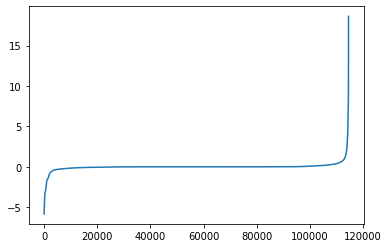

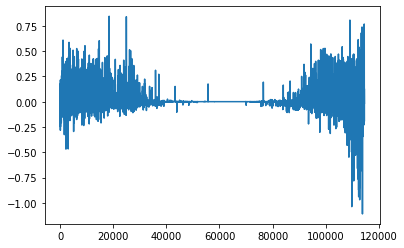

In [46]:
sys.path.append('../../lib/trim')
from trim import TrimModel
from utils import tuple_to_tensor, tensor_to_tuple

mt = TrimModel(model, wt.inverse, use_residuals=True)    
attributer = Attributer(mt, attr_methods='Saliency', device='cuda')

b = torch.tensor([]).to(device)
c = torch.tensor([]).to(device)
for data, _ in test_loader:
    data = data.to(device)
    data_t = wt(data)
    attributions = attributer(data_t, target=0, additional_forward_args=deepcopy(data))
    y, _ = tuple_to_tensor(data_t)
    b = torch.cat((y,b), dim=0)     
    z, _ = tuple_to_tensor(attributions)
    c = torch.cat((z,c), dim=0)
b = b.reshape(-1)
c = c.reshape(-1)
sort_indexes = torch.argsort(b, dim=0, descending=False)          
    
plt.plot(b[sort_indexes].detach().cpu())
plt.show()

plt.plot(c[sort_indexes].detach().cpu())
plt.show()